<a href="https://colab.research.google.com/github/pgbio99/Study_Gene-Expression_-Chemoresistance-in-Cancer_Machine-learning/blob/main/DEA_drug_res_sens_volcano_plt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
import os
import csv

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving GSE15709-GPL570_series_matrix_clean.csv to GSE15709-GPL570_series_matrix_clean.csv
Saving phen_data_15709.csv to phen_data_15709.csv


In [ ]:
output_directory = 'DEA_results'
os.makedirs(output_directory, exist_ok=True)
print(f"Directory '{output_directory}' created successfully (or already exists).")

Directory 'DEA_results' created successfully (or already exists).


In [ ]:
 expression_filepath = 'GSE15709-GPL570_series_matrix_clean.csv'
 label_filepath = 'phen_data_15709.csv'
 group1_name = 'Resistant'
 group2_name = 'Sensitive'
 output_dir = 'DEA_results'
 log2fc_cutoff = 2.0
fdr_cutoff = 0.01

In [ ]:
def perform_differential_expression(
    expression_filepath,
    label_filepath,
    group1_name,
    group2_name,
    log2fc_cutoff,
    fdr_cutoff
):
    print(f"\n--- Starting DEA for {expression_filepath}---")

    try:
        data_df = pd.read_csv(expression_filepath, sep=',', index_col=0, quoting=csv.QUOTE_NONE)
        labels_df = pd.read_csv(label_filepath, sep=',', index_col='Sample_ID')
    except Exception as e:
        print(f"Error loading files. Check separators and paths: {e}")
        return None, None

    data_df.index = data_df.index.astype(str).str.strip().str.replace('"', '', regex=False)
    data_df.columns = data_df.columns.astype(str).str.strip().str.replace('"', '', regex=False).str.replace('^X\\.', '', regex=True)
    labels_df.index = labels_df.index.astype(str).str.strip()

    if len(data_df.index) > 0 and data_df.index[-1].startswith('!'):
        data_df = data_df.iloc[:-1]

    if data_df.shape[0] < data_df.shape[1]:
        print("Note: Transposing data (assuming samples were rows, genes were columns).")
        data_df = data_df.T

    data_df = data_df.apply(pd.to_numeric, errors='coerce').dropna(how='all')

    group_map = labels_df['Phenotype'].to_dict()
    common_samples = data_df.columns.intersection(group_map.keys())

    if len(common_samples) == 0:
        print("Error: No common samples found between expression data and label data after cleaning and aligning.")
        return None, None

    # Filter data and define groups
    data_df = data_df[common_samples]
    group1_samples = [s for s in common_samples if group_map.get(s) == group1_name]
    group2_samples = [s for s in common_samples if group_map.get(s) == group2_name]

    if not group1_samples or not group2_samples:
        print("Error: One or both sample groups are empty. Check your label file names or group names.")
        return None, None

    group1_data = data_df[group1_samples]
    group2_data = data_df[group2_samples]

    results = []
    for gene in data_df.index:
        log2fc = group1_data.loc[gene].mean() - group2_data.loc[gene].mean()

        statistics, p_value = stats.ttest_ind(
            group1_data.loc[gene].dropna().values,
            group2_data.loc[gene].dropna().values,
            equal_var=False
        )
        results.append({'Gene': gene, 'log2FC': log2fc, 'P_Value': p_value})

    dea_results = pd.DataFrame(results).set_index('Gene')

    # Correcting for multiple testing
    p_adjusted = multipletests(dea_results['P_Value'].fillna(1.0), method = 'fdr_bh')[1]
    dea_results['FDR_P_VALUE'] = p_adjusted

    # Filter for significant DEGs
    significant_degs = dea_results[
        (dea_results['log2FC'].abs() >= log2fc_cutoff) &
        (dea_results['FDR_P_VALUE'] <= fdr_cutoff)
    ]

    print(f"Total Genes Analyzed : {len(dea_results)}")
    print(f"Significant DEGs Found (Log2FC >= {log2fc_cutoff}, FDR <= {fdr_cutoff}): {len(significant_degs)}")

    return dea_results, significant_degs

In [ ]:
print("--- Calling the DEA function ---")
all_results_df, significant_degs_df = perform_differential_expression(
    expression_filepath=expression_filepath,
    label_filepath=label_filepath,
    group1_name=group1_name,
    group2_name=group2_name,
    log2fc_cutoff=log2fc_cutoff,
    fdr_cutoff=fdr_cutoff
)

if all_results_df is not None:
    all_results_filename = os.path.join(output_dir, 'all_dea_results_3.csv')
    all_results_df.to_csv(all_results_filename)
    print(f"\nFull DEA results saved to: {all_results_filename}")

    significant_filename = os.path.join(output_dir, 'significant_DEGs_3.csv')
    significant_degs_df.to_csv(significant_filename)
    print(f"Significant DEGs saved to: {significant_filename}")

--- Calling the DEA function ---

--- Starting DEA for GSE15709-GPL570_series_matrix_clean.csv---
Total Genes Analyzed : 54675
Significant DEGs Found (Log2FC >= 2.0, FDR <= 0.01): 362

Full DEA results saved to: DEA_results/all_dea_results_3.csv
Significant DEGs saved to: DEA_results/significant_DEGs_3.csv


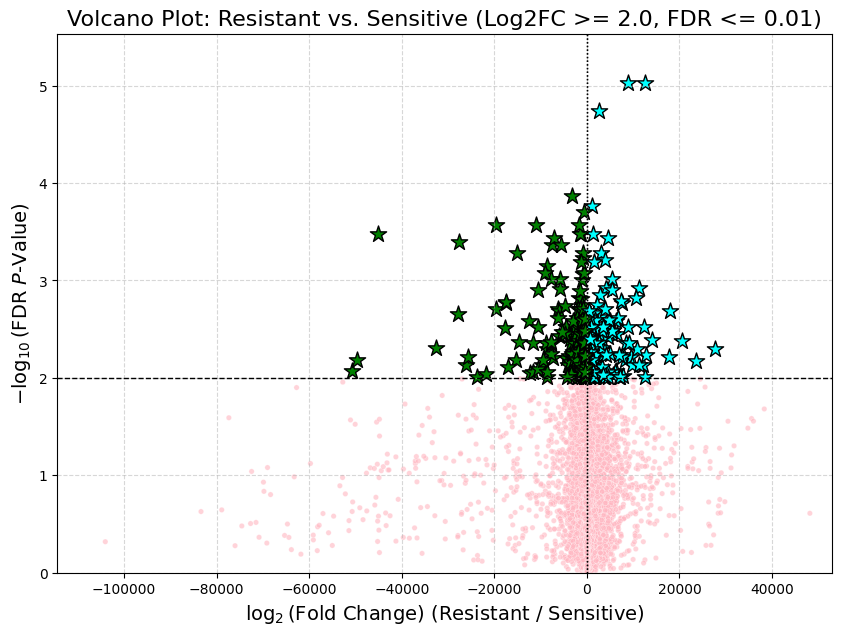

Volcano plot saved as a PNG file.


<Figure size 640x480 with 0 Axes>

In [ ]:
input_filepath = 'DEA_results/all_dea_results_3.csv'
log2fc_cutoff = 2.0
fdr_cutoff = 0.01

try:
    df = pd.read_csv(input_filepath)
    df['FDR_P_VALUE'] = df['FDR_P_VALUE'].replace(0, np.finfo(float).eps)
    df['neg_log10_FDR'] = -np.log10(df['FDR_P_VALUE'])

    df['Regulation'] = 0
    df.loc[(df['FDR_P_VALUE'] <= fdr_cutoff) & (df['log2FC'] >= log2fc_cutoff), 'Regulation'] = 1
    df.loc[(df['FDR_P_VALUE'] <= fdr_cutoff) & (df['log2FC'] <= -log2fc_cutoff), 'Regulation'] = -1

    colors = {0: 'lightpink', 1: '#00FFFF', -1: '#008000'}
    fdr_threshold = -np.log10(fdr_cutoff)

except FileNotFoundError:
    print(f"Error: Results file not found at {input_filepath}. Run your DEA script first.")
    raise

# Generate the Volcano Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df,
    x='log2FC',
    y='neg_log10_FDR',
    hue='Regulation',
    palette=colors,
    s=15, # marker size
    alpha=0.6,
    legend=False
)

#Significance Threshold (Horizontal Line)
plt.axhline(
    y=fdr_threshold,
    color='black',
    linestyle='--',
    linewidth=1,
    label=f'FDR = {fdr_cutoff}'
)

#Log2FC Thresholds (Vertical Lines)
plt.axvline(
    x=log2fc_cutoff,
    color='black',
    linestyle=':',
    linewidth=1,
    label=f'|Log2FC| = {log2fc_cutoff}'
)
plt.axvline(
    x=-log2fc_cutoff,
    color='black',
    linestyle=':',
    linewidth=1
)

plt.title(
    f'Volcano Plot: Resistant vs. Sensitive (Log2FC >= {log2fc_cutoff}, FDR <= {fdr_cutoff})',
    fontsize=16
)
plt.xlabel(r'$\log_2$(Fold Change) (Resistant / Sensitive)', fontsize=14)
plt.ylabel(r'$-\log_{10}(\text{FDR } P\text{-Value})$', fontsize=14)

significant_genes = df[df['Regulation'] != 0]
for line in significant_genes.itertuples():
    plt.scatter(line.log2FC, line.neg_log10_FDR, color=colors[line.Regulation], marker='*', s=150, edgecolors='black')

max_y = df['neg_log10_FDR'].max() * 1.1
plt.ylim(0, max_y)
plt.xlim(df['log2FC'].min() * 1.1, df['log2FC'].max() * 1.1)

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

plt.savefig(f'{input_filepath.replace(".csv", "_volcano_2.png")}', dpi=300)
print("Volcano plot saved as a PNG file.")